In [23]:
%reset -f

In [24]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR

In [25]:
with open('/Users/cristianosalvagnin/Documents/GitHub/EUA_Volatility_DII_p/Data/quadratic_and_linear_XY_to_Z.p', 'rb') as file:
    traj = pickle.load(file)

In [26]:
scaler = StandardScaler()
scaler.fit(traj)
traj = scaler.transform(traj)

In [27]:
df = pd.DataFrame()
df['Z (Target)'] = traj[:,2]
df['Y'] = traj[:,1]
df['X'] = traj[:,0]
df = df[5000:7902]

In [28]:
model = VAR(df)
var_model = model.fit(maxlags=1, trend='n', verbose=True)  # 1 lag
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 28, Dec, 2024
Time:                     11:18:50
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                  -0.460869
Nobs:                     2901.00    HQIC:                 -0.472722
Log likelihood:          -11644.7    FPE:                   0.619155
AIC:                    -0.479399    Det(Omega_mle):        0.617239
--------------------------------------------------------------------
Results for equation Z (Target)
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
L1.Z (Target)         0.478768         0.014036           34.110           0.000
L1.Y                  0.002084         0.014178            0.147           0.883
L1.X                  0.448049         0.013995        

In [29]:
target_coef = abs(var_model.params['Z (Target)'])


In [30]:
target_coef.index.str.replace('L1.', '')


Index(['Z (Target)', 'Y', 'X'], dtype='object')

In [31]:
target_coef = target_coef.reset_index()
target_coef.columns = ['Variable', 'VAR Coeff.']
print(target_coef)

        Variable  VAR Coeff.
0  L1.Z (Target)    0.478768
1           L1.Y    0.002084
2           L1.X    0.448049


In [32]:
target_coef['Variable'] = target_coef['Variable'].str.replace('L1.', '')
print(target_coef)

     Variable  VAR Coeff.
0  Z (Target)    0.478768
1           Y    0.002084
2           X    0.448049


In [33]:
causality_results = []

for var in df.columns:
    
    causality = var_model.test_causality('Z (Target)', var, kind='f')

    causality_results.append({
        'Excluded Variable': var,
        'F-Statistic': causality.test_statistic,
        'p-value': causality.pvalue
    })

causality_results_df = pd.DataFrame(causality_results)
print(causality_results_df)

  Excluded Variable  F-Statistic        p-value
0        Z (Target)  1163.462970  1.934564e-239
1                 Y     0.021610   8.831338e-01
2                 X  1024.975751  1.051474e-212


In [34]:
with open('/Users/cristianosalvagnin/Documents/GitHub/EUA_Volatility_DII_p/Data/weights_toymodel.p', 'rb') as file:
    DII_toy = pickle.load(file)

In [35]:
df_DII_toy = pd.DataFrame(DII_toy)
df_DII_toy.columns = ['DII Coeff.']
print(df_DII_toy)

   DII Coeff.
0    0.068511
1    0.135314
2    0.083644


In [36]:
df_DII_toy['Variable'] = ['Z (Target)', 'Y', 'X']
df_DII_toy = df_DII_toy[['Variable', 'DII Coeff.']]
print(df_DII_toy)

     Variable  DII Coeff.
0  Z (Target)    0.068511
1           Y    0.135314
2           X    0.083644


In [37]:
merged_df = pd.merge(target_coef, df_DII_toy, on='Variable', how='inner')
print(merged_df)

     Variable  VAR Coeff.  DII Coeff.
0  Z (Target)    0.478768    0.068511
1           Y    0.002084    0.135314
2           X    0.448049    0.083644


In [38]:
causality_results_df = causality_results_df.drop(columns=['p-value'])
causality_results_df.columns = ['Variable', 'F-Statistic']
print(causality_results_df)

     Variable  F-Statistic
0  Z (Target)  1163.462970
1           Y     0.021610
2           X  1024.975751


In [39]:
with open('/Users/cristianosalvagnin/Documents/GitHub/EUA_Volatility_DII_p/Data/IGs_toymodel.p', 'rb') as file:
    IG_toy = pickle.load(file)

print(IG_toy)

[22.49288125 27.72234305 29.15142412]


In [40]:
df_IG_toy = pd.DataFrame(IG_toy)
df_IG_toy.columns = ['IG Coeff.']
print(df_IG_toy)

   IG Coeff.
0  22.492881
1  27.722343
2  29.151424


In [41]:
df_IG_toy['Variable'] = ['Z (Target)', 'Y', 'X']
df_IG_toy = df_IG_toy[['Variable', 'IG Coeff.']]
print(df_IG_toy)

     Variable  IG Coeff.
0  Z (Target)  22.492881
1           Y  27.722343
2           X  29.151424


In [42]:
merged_df_2 = pd.merge(causality_results_df, df_IG_toy, on='Variable', how='inner')
print(merged_df_2)

     Variable  F-Statistic  IG Coeff.
0  Z (Target)  1163.462970  22.492881
1           Y     0.021610  27.722343
2           X  1024.975751  29.151424


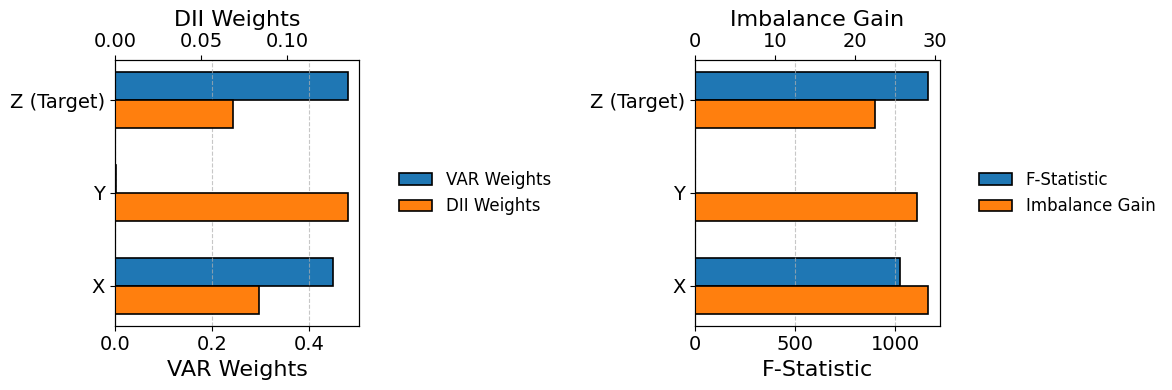

In [ ]:
variables = target_coef['Variable']
indices = np.arange(len(variables))
bar_width = 0.3

fig, axes = plt.subplots(1, 2, figsize=(12, 10))

bar_kwargs = {"edgecolor": "black", "linewidth": 1.2}

ax1 = axes[0]
ax2 = ax1.twiny()

bar1 = ax1.barh(
    indices - bar_width / 2,
    target_coef["VAR Coeff."], 
    bar_width, 
    color='tab:blue', 
    label="VAR Weights",
    **bar_kwargs
)

bar2 = ax2.barh(
    indices + bar_width / 2,
    df_DII_toy["DII Coeff."], 
    bar_width, 
    color='tab:orange', 
    label="DII Weights",
    **bar_kwargs
)

ax1.set_xlabel("VAR Weights", fontsize=16)
ax2.set_xlabel("DII Weights", fontsize=16)
ax1.set_yticks(indices)
ax1.set_yticklabels(variables, fontsize=14)
ax1.invert_yaxis()
ax1.grid(axis='x', linestyle='--', alpha=0.7)

ax1.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='x', labelsize=14)

variables = causality_results_df['Variable']
ax3 = axes[1]
ax4 = ax3.twiny()

bar3 = ax3.barh(
    indices - bar_width / 2,
    causality_results_df["F-Statistic"], 
    bar_width, 
    color='tab:blue', 
    label="F-Statistic",
    **bar_kwargs
)

bar4 = ax4.barh(
    indices + bar_width / 2,
    df_IG_toy["IG Coeff."], 
    bar_width, 
    color='tab:orange', 
    label="Imbalance Gain",
    **bar_kwargs
)

ax3.set_xlabel("F-Statistic", fontsize=16)
ax4.set_xlabel("Imbalance Gain", fontsize=16)
ax3.set_yticks(indices)
ax3.set_yticklabels(variables, fontsize=14)
ax3.invert_yaxis()
ax3.grid(axis='x', linestyle='--', alpha=0.7)

ax3.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='x', labelsize=14)

handles_left = [bar1, bar2]
labels_left = ["VAR Weights", "DII Weights"]
handles_right = [bar3, bar4]
labels_right = ["F-Statistic", "Imbalance Gain"]

axes[0].legend(
    handles_left, labels_left, loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=12, frameon=False
)
axes[1].legend(
    handles_right, labels_right, loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=12, frameon=False
)

plt.tight_layout(rect=[0, 0.1, 1, 0.5])
plt.show()


***